In [1]:
#default_exp anime.dataloader

In [2]:
#export
import pandas as pd
from pathlib import Path
import json
from functools import partial
from PIL import Image
import numpy as np
from itertools import chain
from fast.torch_basics import *
from fast.layers import *
from fast.data.all import *
from fast.data.block import *
from fast.optimizer import *
from fast.learner import *
from fast.metrics import *
from fast.callback.all import *
from fast.vision.all import *
from anime.ugatit import *
from fast.callback.wandb import WandbCallback
from anime.kid import *
import wandb
from fast.fp16_utils import convert_module
#from fast.callback.tensorboard import TensorBoardCallback

In [3]:
# True = use GPU
defaults.use_cuda=True 
path=Path("/home/fast/.fastai/data/danbooru2018")
meta_path=path/'metadata/2018000000000016'
portraits=pd.read_pickle(path/'portraits')
selfie_path=Path('/home/fast/.fastai/data/Selfie-dataset')
self_txt= selfie_path/'selfie_dataset.txt'
self_txt.exists()
attrs='image_name popularity partial_faces is_female baby child teenager youth middle_age senior white black asian oval_face round_face heart_face smiling mouth_open frowning wearing_glasses wearing_sunglasses wearing_lipstick tongue_out duck_face black_hair blond_hair brown_hair red_hair curly_hair straight_hair braid_hair showing_cellphone using_earphone using_mirror braces wearing_hat harsh_lighting dim_lighting'.split()
img_size=512 #needs to be >96 oherwise loss is nan

In [4]:
lr=0.0001
wd=0.0001

## Tag comparison

In [5]:
def getSelfiePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/((dft['image_name']).values[0]+'.jpg')
    return (dft.values,path)
def getImagePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/'512px'/(dft['directory']+'/'+dft['file']).values[0]
    return (dft.tags.values[0],path)

In [6]:
class DSList():
    def __init__(self,name='selfie2anime'):
        self.name=name
    def __call__(self):
        if(self.name=='selfie2anime'):
            return self._selfie2anime()
        elif(self.name=='_danbooru'):
            return self._danbooru()
    def _danbooru(self):
        def txt_to_path(img,dir=dir,ext='.jpg'):
            return dir/(img+ext)
        selfies=pd.read_pickle(selfie_path/'selfies')
        selfie_imgs=L(list(selfies['image_name'].apply(partial(txt_to_path,dir=selfie_path/'images'))))
        f=partial(txt_to_path,dir=path/'512px',ext='')
        locs=portraits['directory']+'/'+portraits['file']
        anime_imgs=L(list(locs.apply(f)))
        return selfie_imgs,anime_imgs
    def _selfie2anime(self):
        selfie_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainA").ls())
        anime_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainB").ls())
        return selfie_imgs,anime_imgs
selfie_imgs,anime_imgs=DSList()()
len(anime_imgs),len(selfie_imgs)

(3400, 3400)

In [7]:
tfms = [PILImage.create]
ds_img_tfms = [ToTensor()]

In [8]:
TensorImageBase??

In [9]:
class CycleImage(Tuple):
    def toTensor(self):
        img1,img2 = self
        return torch.cat([img1,img2], dim=2)
    def show(self, ctx=None, **kwargs): 
        return show_image(self.toTensor(),  ctx=ctx)

In [10]:
class CyclePair(Transform):
    def __init__(self,bItems):
        self.small = bItems #(aItems,bItems) if len(aItems)>len(bItems) else (bItems,aItems)
        self.assoc = self
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        return CycleImage(i, random.choice(self.small)) #CycleImage(self.large[i], random.choice(self.small))

In [11]:
class ToTensorTuple(TupleTransform):
    "Convert item to appropriate tensor class"
    order = 15
@ToTensorTuple
def encodes(self, o:CycleImage): return TensorImage(image2byte(o))

In [12]:
data_stats={'selfie_means':torch.Tensor([143.81911227601947, 119.46716940677527, 113.92494676532168]),
 'selfie_stds':torch.Tensor([67.72407215465199, 64.41496156519109, 52.516515323610015]),
 'anime_means':torch.Tensor([173.24273681640625, 155.69161987304688, 135.62557983398438]),
 'anime_stds':torch.Tensor([51.790767669677734, 48.620208740234375, 48.380496978759766])}
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        x=tensor(x).permute(2,0,1).float()
    elif x.ndim==2:
        x=tensor(x)[None].repeat(3,1,1).float()
    if(fn.parent.name=='trainA'):
        return (x-data_stats['selfie_means'][:,None][:,None])/data_stats['selfie_stds'][:,None][:,None]
    elif(fn.parent.name=='trainB'):
        return (x-data_stats['anime_means'][:,None][:,None])/data_stats['anime_stds'][:,None][:,None]
    raise ValueError('The path was not expected '+str(fn))
#OpenAndResize = TupleTransform(partial(resized_image,sz=img_size))

In [13]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        return TensorImage(tensor(x).permute(2,0,1).float()/255.)
    elif x.ndim==2:
        return TensorImage(tensor(x)[None].repeat(3,1,1).float()/255.)
OpenAndResize = TupleTransform(partial(resized_image,sz=img_size))

In [14]:
tm=[CyclePair(anime_imgs), OpenAndResize, IntToFloatTensor(div=False)]#+[ToTensorTuple(),]

In [15]:
class Half(Transform):
    order=70
    "Move batch to `device` (defaults to `default_device()`)"
    def __init__(self,dtype=torch.half):
        self.dtype=dtype
        super().__init__(split_idx=None, as_item=False)
    def encodes(self, b): 
        print(type(b))
        return to_half(b)
    def decodes(self, b): return to_float(b)

    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")

In [16]:
class ListofTransformsforTuple(TupleTransform):
    "Convert item to appropriate tensor class"
    order = 60
    def __init__(self, transforms):
        self.transforms=transforms
    def encodes(self, o:CycleImage): 
        o1,o2=o
        o1,o2=TensorImage(o1),TensorImage(o2)
        
        for t in self.transforms:
            o1,o2=t(o1),t(o2)
        return CycleImage(o1,o2)
transforms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2,max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,size=None, mode='bilinear', pad_mode=PadMode.Reflection)
transforms=ListofTransformsforTuple(transforms)

In [17]:
after_batch=[Cuda(),transforms,Half()]#,aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2,max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,size=None, mode='bilinear', pad_mode=PadMode.Reflection)]
                    #aug_transforms(do_flip=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2)        
                    #Cuda(),#+aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2,
                   #max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,
                   #size=None, mode='bilinear', pad_mode=PadMode.Reflection)
tfm=Pipeline(tm, as_item=False) #+after_batch

In [18]:
class NoopTensor(Transform):
    def encodes(self, x): return CycleImage(torch.Tensor([[[0]]]),torch.Tensor([[[0]]])) #needs to match output of network type

In [19]:
tfm2=Pipeline([NoopTensor()],as_item=False)

In [20]:
val_path=selfie_imgs[0].parent
val = ['female_10686.jpg',
 'female_10367.jpg',
 'female_30988.jpg',
 'female_8194.jpg',
 'female_18724.jpg',
 'female_10087.jpg',
 'female_27647.jpg',
 'female_13409.jpg',
 'female_20608.jpg',
 'female_26279.jpg',
 'female_7103.jpg',
 'female_10615.jpg',
 'female_25884.jpg',
 'female_31235.jpg',
 'female_28991.jpg',
 'female_9936.jpg',
 'female_33285.jpg',
 'female_33491.jpg',
 'female_1597.jpg',
 'female_13893.jpg',
 'female_26481.jpg',
 'female_32384.jpg',
 'female_18827.jpg',
 'female_19176.jpg',
 'female_6150.jpg',
 'female_1487.jpg',
 'female_13914.jpg',
 'female_29264.jpg',
 'female_17571.jpg',
 'female_32817.jpg',
 'female_7374.jpg',
 'female_16798.jpg',
 'female_21739.jpg',
 'female_22605.jpg',
 'female_21305.jpg',
 'female_12988.jpg',
 'female_4297.jpg',
 'female_9025.jpg',
 'female_13560.jpg',
 'female_31712.jpg',
 'female_1177.jpg',
 'female_13787.jpg',
 'female_11117.jpg',
 'female_10664.jpg',
 'female_17134.jpg',
 'female_16420.jpg',
 'female_95.jpg',
 'female_15298.jpg',
 'female_32776.jpg',
 'female_9353.jpg',
 'female_22181.jpg',
 'female_32015.jpg',
 'female_27565.jpg',
 'female_19001.jpg',
 'female_8955.jpg',
 'female_33094.jpg',
 'female_7486.jpg',
 'female_32167.jpg',
 'female_28716.jpg',
 'female_6519.jpg',
 'female_4339.jpg',
 'female_24557.jpg',
 'female_20786.jpg',
 'female_26695.jpg',
 'female_25546.jpg',
 'female_15424.jpg',
 'female_711.jpg',
 'female_31004.jpg',
 'female_9440.jpg',
 'female_22912.jpg',
 'female_2754.jpg',
 'female_24839.jpg',
 'female_12741.jpg',
 'female_9480.jpg',
 'female_15677.jpg',
 'female_23557.jpg',
 'female_3006.jpg',
 'female_29858.jpg',
 'female_8664.jpg',
 'female_16808.jpg',
 'female_32694.jpg',
 'female_5019.jpg',
 'female_15584.jpg',
 'female_32256.jpg',
 'female_5747.jpg',
 'female_22101.jpg',
 'female_4115.jpg',
 'female_20185.jpg',
 'female_25131.jpg',
 'female_31061.jpg',
 'female_2546.jpg',
 'female_30868.jpg',
 'female_17341.jpg',
 'female_9415.jpg',
 'female_14142.jpg',
 'female_11470.jpg',
 'female_683.jpg',
 'female_3433.jpg',
 'female_19286.jpg',
 'female_30070.jpg']

In [21]:
val_path.ls()

(#3400) [/home/fast/.fastai/data/selfie2anime/trainA/female_10.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10016.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10020.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10025.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_1003.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10042.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10044.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10055.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10057.jpg,/home/fast/.fastai/data/selfie2anime/trainA/female_10074.jpg...]

In [22]:
selfieL=0
selfieL=len(selfie_imgs)-100 if selfieL<3 or selfieL>len(selfie_imgs)-100 else selfieL
selfie_sample=selfie_imgs.filter(lambda s:s.name in val,negate=True)
selfie_sample=selfie_sample.shuffle()[0:selfieL]
selfie_sample=selfie_sample+map(lambda v:val_path/v,val)
#val_size=100#20 if selfieL>24 else selfieL//2
#val=selfie_sample[0:val_size] set above
tfmDs=DataSource(selfie_sample,[tfm,tfm2],splits=[[selfie.name not in val for selfie in selfie_sample],[selfie.name in val for selfie in selfie_sample]])

In [23]:
dl=TfmdDL(tfmDs,bs=1, shuffle=False, num_workers=8,after_batch=after_batch)

In [24]:
db=dl.databunch(bs=1,val_bs=1,after_batch=after_batch)
# DataBunch(dl) testing above

In [25]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    for i in range_of(samples[0]):
        [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    return ctxs

In [26]:
#selfie_stds=[selfie[0][0].std() for selfie in iter(dl)]
#anime_stds=[anime[0][1].std() for anime in iter(dl)]
#sum(selfie_stds)/len(selfie_stds),sum(anime_stds)/len(anime_stds)

<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>


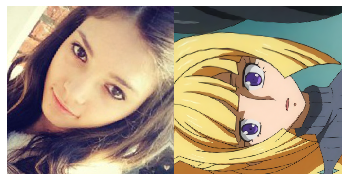

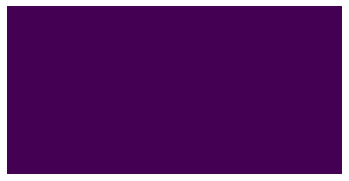

In [27]:
dl.show_batch()

<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>
<class '__main__.CycleImage'>


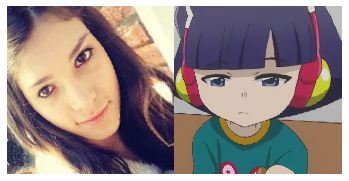

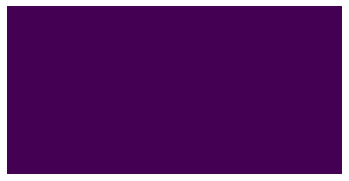

In [28]:
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[0][1][0]).show()
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[1][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[1][1][0]).show()

<class '__main__.CycleImage'>
<class '__main__.CycleImage'>


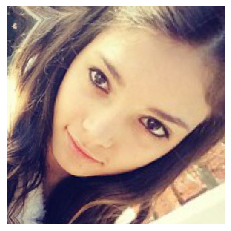

In [29]:
show_image(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0])

In [30]:
db.show_batch()

ZeroDivisionError: float division by zero

In [ ]:
class LossNorm(nn.Module):
    #Maybe have batchnorm scaling params?
    def __init__(self):
        super(LossNorm, self).__init__()
    def foward(self, x):
        return x,x.mean(),x.std()

In [ ]:
make normalization of mean 0 std 1 as part of the loss function
Why relu and not tanh insterad? 
Should we only penalize most "recent" conv, and not go back many layers? 

In [ ]:
e^sqrt()

In [33]:
ResBlock??